<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/vae_conv_mnist_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder for Handwritten Digit


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it.

In [2]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows, img_cols, 1)
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 28, 28, 1)
60000 train samples, 10000 test samples


## The model

In [4]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2
strides = 2
padding = 'same'

### Fill in the empty block to complete building an encoder model

In [5]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2

# build encoder model
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs

***fill in the code in the following block to reflect the encoder in the VAE***

In [6]:
# Encoder: conv -> (save shape) -> flatten -> dense -> (mu, log_sigma)

x = layers.Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  activation='relu',
                  strides=2,
                  padding='same')(x)

# Save the shape info for decoder (needed for Dense + Reshape)
shape = K.int_shape(x)

# Flatten and map to a small hidden representation
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Latent variables: mean and log-variance (log_sigma)
mu = layers.Dense(latent_dim, name='mu')(x)
log_sigma = layers.Dense(latent_dim, name='sigma')(x)


### Build a decoder model

In [7]:
# use reparameterization trick to push the sampling out as input instead of sampling from Q(z|X)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps

    Arguments:
        args:       mean and log of variance of Q(z|X)

    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))

    return mean + K.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_sigma])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    100,368 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma (Dense)       │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ mu[0][0],         │
│                     │                   │            │ sigma[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,756 (393.58 KB)

 Trainable params: 100,756 (393.58 KB)

 Non-trainable params: 0 (0.00 B)

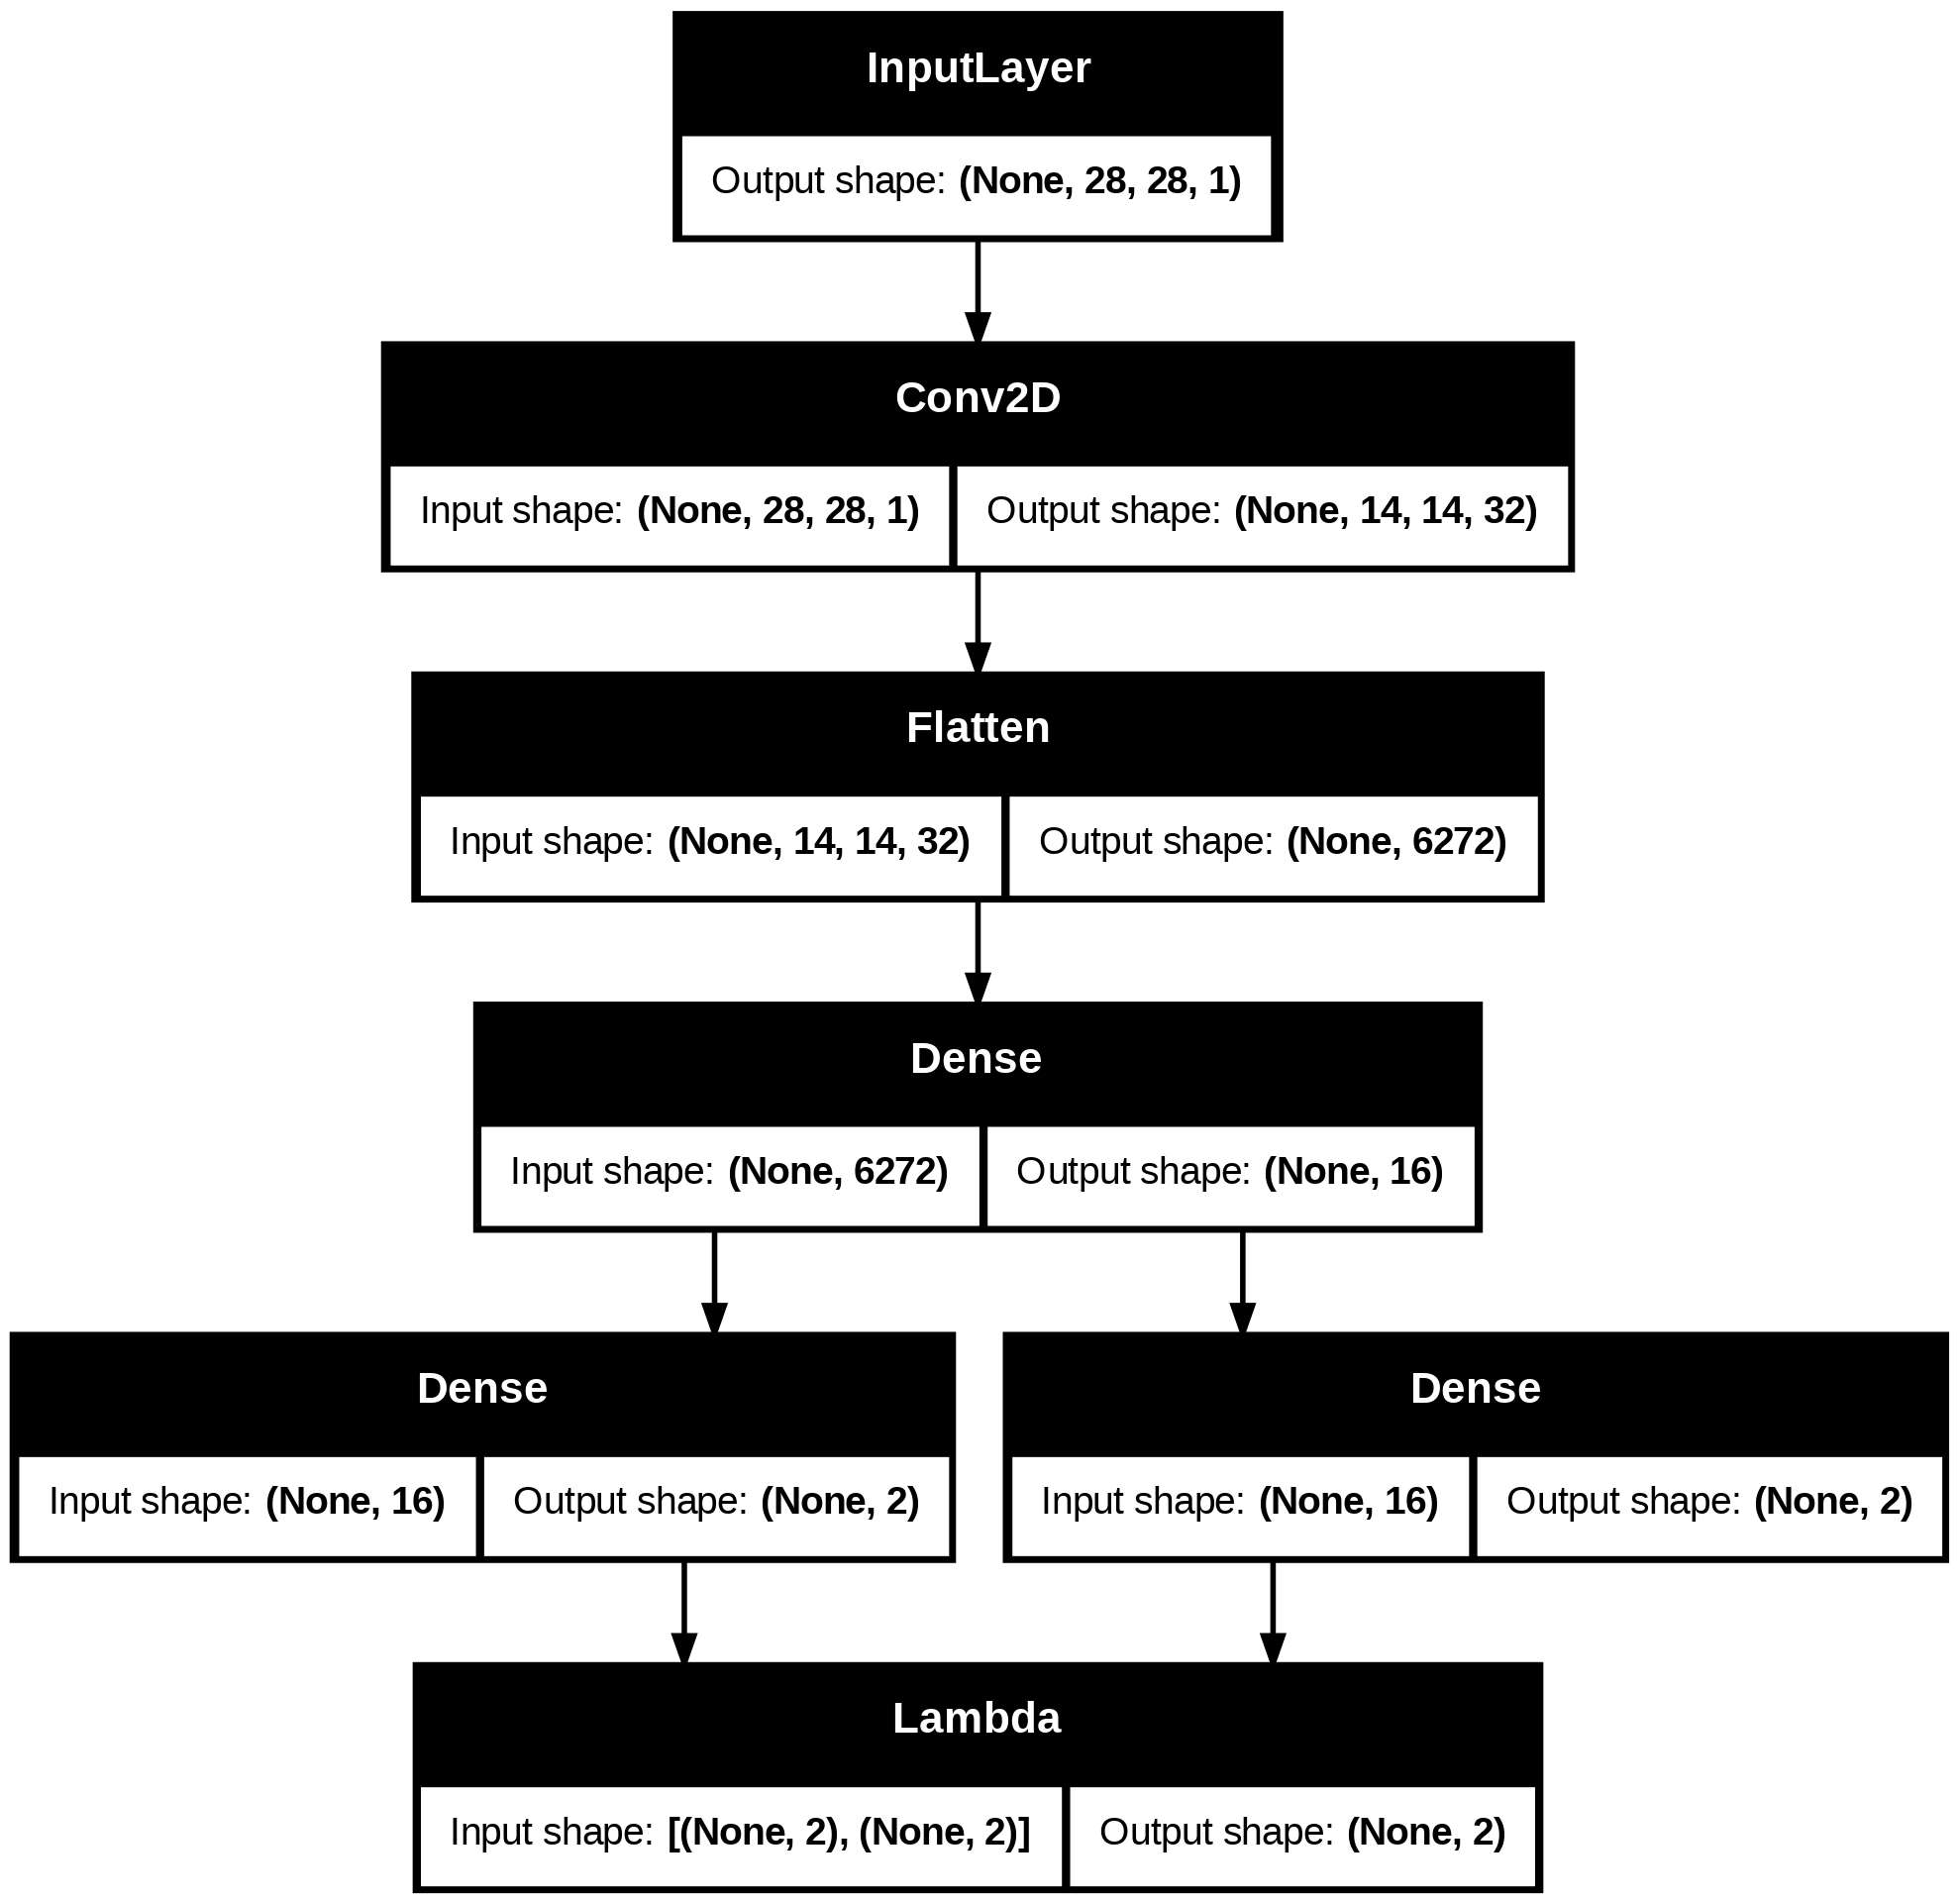

In [8]:
# instantiate encoder model
encoder = Model(inputs, [mu, log_sigma, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6272)           │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,209 (453.94 KB)

 Trainable params: 116,209 (453.94 KB)

 Non-trainable params: 0 (0.00 B)

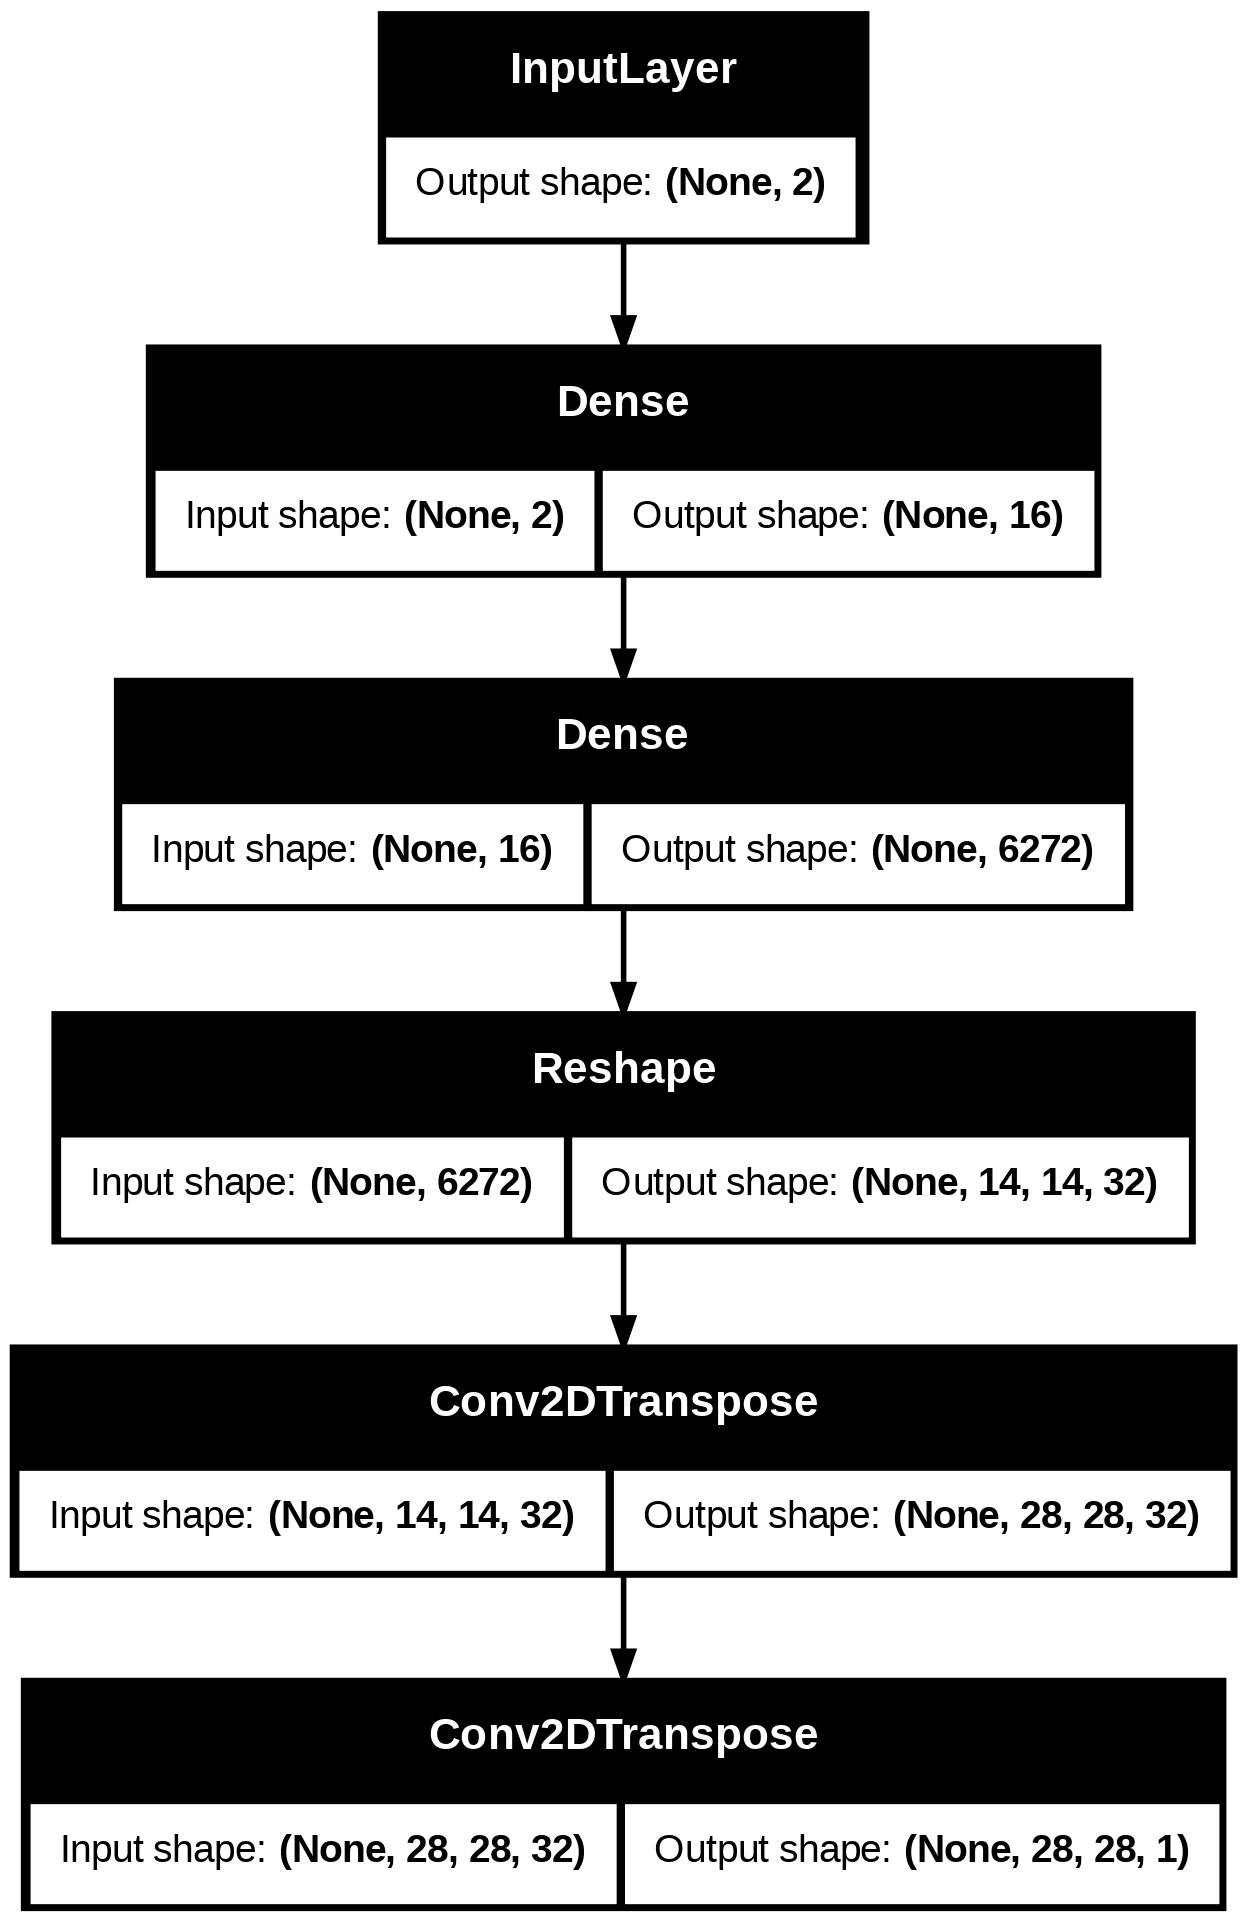

In [9]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

x = layers.Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           strides=2,
                           padding='same')(x)

outputs = layers.Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

In [10]:
# Create a Custom Layer to Compute and Add the Loss
class VAELossLayer(layers.Layer):
    def __init__(self, img_rows, img_cols, **kwargs):
        self.img_rows = img_rows
        self.img_cols = img_cols
        super(VAELossLayer, self).__init__(**kwargs)
    def call(self, inputs):
        encoder_inputs, decoder_outputs, mu, log_sigma = inputs
        reconstruction_loss = mse(K.flatten(encoder_inputs),
                                                  K.flatten(decoder_outputs))
        reconstruction_loss *= self.img_rows * self.img_cols
        kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(K.mean(total_loss))
        return decoder_outputs

In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # Connect decoder to encoder output

# Wrap the Loss Computation in the Custom Layer
# The loss will be computed and added to the model when this layer is called.
loss_layer = VAELossLayer(img_rows, img_cols, name='vae_loss')([inputs, outputs, mu, log_sigma])

# Build the VAE Model with the loss layer included
vae = Model(inputs, [outputs, loss_layer], name='vae_model')  # Include loss layer in outputs

vae.compile(optimizer=keras.optimizers.RMSprop(0.003))

In [12]:
BATCH = 100
EPOCHS = 20

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 49.2302
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42.6335
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.4196
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 40.6110
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 40.1708
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.6981
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.4091
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.0532
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.9762
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.7900
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.6740
Epoch 12/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 38.5212
Epoch 13/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 38.3268
Epoch 14/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.2585
Epoch 15/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s

In [13]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


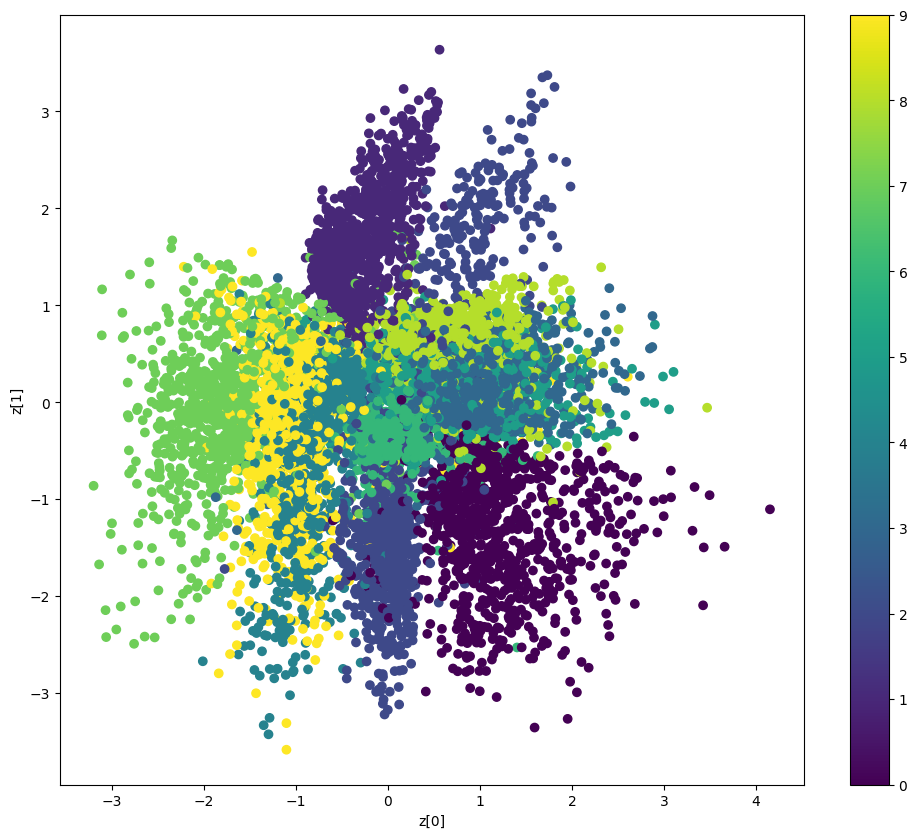

In [14]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_cnn")